# settings

In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr
from scipy.io import savemat
from utils import daily_blocks, extract_all_licks, get_tone_response_df, block_stim_evoke_response

plt.rcParams['axes.facecolor'] = 'white'
outcome_list = ['Hit', 'Miss', 'FA', 'CR']
mouse_names = ['jl009', 'fz017', 'fz009', 'fz006']
data_paths = ["Z:/Jenni/jl009/behavimaging.mat",
             "W:/Jenni/fz017/behavimaging.mat",
             "Y:/Jenni/fz009/behavimaging.mat",
             "Y:/sarah/fz006/behavimaging.mat"]
disks = ['Z', 'W', 'Y', 'Y']

mouse_id = 0
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
nBlocks = data.shape[-1]
nDays = data[0, -1]['day'][0][0]

In [2]:
plt.rcParams.update({'font.size': 16})

# prelick trial distribution with different outcome history

In [3]:
# find Miss-Miss, CR-Miss Pairs
from scipy.stats import zscore
def block_pair_response(block, pair=[1, 1]):
    '''
    return responses of a pair of outcome
    pair: a list with two values, first value for pre-outcome, second value for post-outcome. 
    1-4: Hit, Miss, FA, CR
    '''
    raw_spks = block['imagingdata']
    NA, NT = raw_spks.shape
    spks = zscore(raw_spks, axis=1)

    behavior = block['behavdata']
    istim = np.where(behavior[0] > 0)[0] # cue onset frames
    cues = behavior[0, istim]
    outcomes = behavior[1, istim]
    ifirstlicks = -np.ones(len(istim))
    licks = behavior[3]

    all_df = []
    all_licks = []
    # use zscore
    for i,k in enumerate(istim[:-1]):
        outcome_pair = [outcomes[i], outcomes[i+1]]
        pre_range = range((k - 30), (k+45))
        post_range = range((istim[i+1] - 30), (istim[i+1] + 45))
        if outcome_pair == pair:
            all_df.append(np.hstack([spks[:, pre_range], spks[:, post_range]]))
            all_licks.append(np.hstack([licks[pre_range], licks[post_range]]))
            # all_licks.append(licks[post_range])
    if len(all_df) > 0:
        all_df = np.stack(all_df)
        all_licks = np.stack(all_licks)
    return outcomes, all_df, all_licks

In [4]:
from utils import daily_blocks, block_stim_evoke_response

valid_days = []
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)

nt_prelick_all = []
nt_noprelick_all = []
for day in valid_days:
    nt_prelick = np.zeros((4, 4))
    nt_noprelick = np.zeros((4, 4))
    for p1 in range(1, 5):
        for p2 in range(1, 5):
            pair = [p1, p2]
            iblocks = daily_blocks(data, day)
            if len(iblocks)>0:
                daily_cues = []
                daily_outcomes = []
                daily_responses = []
                daily_alllicks = []
                for i in iblocks:
                    block = data[0, i]
                    # normalize doesn't have much effect on the result, so set it to False
                    outcomes, stim_resp, alllicks = block_pair_response(block, pair)
                    if len(stim_resp) > 0:
                        daily_outcomes.append(outcomes)
                        daily_responses.append(stim_resp)
                        daily_alllicks.append(alllicks)
                    
                if len(daily_responses) > 0:
                    daily_outcomes = np.hstack(daily_outcomes)
                    daily_responses = np.vstack(daily_responses)
                    daily_alllicks = np.vstack(daily_alllicks)
                    n_prelicks = np.sum(daily_alllicks[:, 75:90], axis=1)
                    lick_idx = np.where(n_prelicks != 0)[0]
                    nolick_idx = np.where(n_prelicks == 0)[0]
                    nt_prelick[p1-1, p2-1] = len(lick_idx)
                    nt_noprelick[p1-1, p2-1] = len(nolick_idx)
                else:
                    print('no such pair in day {}'.format(day), pair)
    nt_prelick_all.append(nt_prelick)
    nt_noprelick_all.append(nt_noprelick)

no such pair in day 4 [1, 2]
no such pair in day 5 [1, 2]
no such pair in day 5 [2, 2]
no such pair in day 5 [2, 4]
no such pair in day 5 [3, 2]
no such pair in day 7 [2, 3]
no such pair in day 7 [3, 2]
no such pair in day 8 [2, 3]
no such pair in day 8 [3, 2]
no such pair in day 9 [2, 3]
no such pair in day 9 [3, 2]
no such pair in day 15 [2, 1]
no such pair in day 15 [3, 2]


In [5]:
nt_prelick_all = np.stack(nt_prelick_all)
nt_noprelick_all = np.stack(nt_noprelick_all)
print(nt_prelick_all.shape, nt_noprelick_all.shape)

(10, 4, 4) (10, 4, 4)


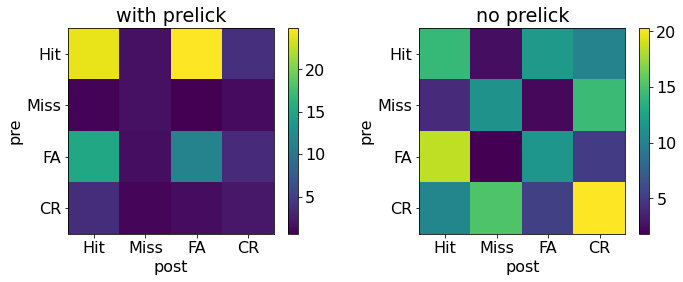

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(np.mean(nt_prelick_all, axis=0))
plt.xticks(ticks=np.arange(4), labels=outcome_list)
plt.yticks(ticks=np.arange(4), labels=outcome_list)
plt.ylabel('pre')
plt.xlabel('post')
plt.colorbar()
plt.title('with prelick')
plt.subplot(122)
plt.imshow(np.mean(nt_noprelick_all, axis=0))
plt.xticks(ticks=np.arange(4), labels=outcome_list)
plt.yticks(ticks=np.arange(4), labels=outcome_list)
plt.colorbar()
plt.title('no prelick')
plt.ylabel('pre')
plt.xlabel('post')
plt.tight_layout()

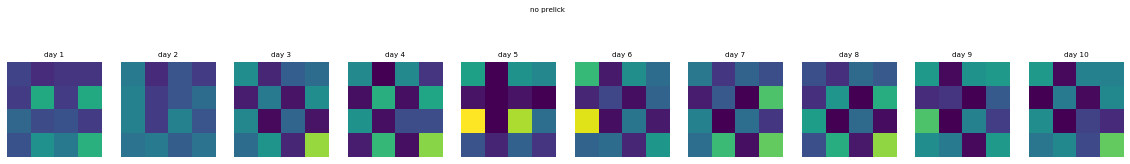

In [139]:
plt.figure(figsize=(20, 3))
plt.rcParams.update({'font.size': 6})
nDay = len(valid_days)
for d in range(nDay):
    plt.subplot(1, nDay, d+1)
    plt.imshow(nt_noprelick_all[d]/np.sum(nt_noprelick_all[d]), vmin=0, vmax=0.2)
    plt.axis('off')
    plt.title('day {}'.format(d+1))
plt.suptitle('no prelick')
plt.show()

Text(0.5, 0.98, 'prelick')

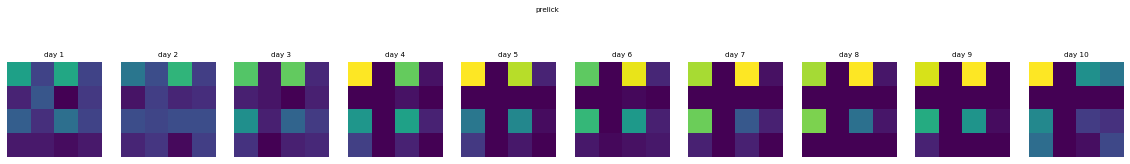

In [141]:
plt.figure(figsize=(20, 3))
plt.rcParams.update({'font.size': 6})
nDay = len(valid_days)
for d in range(nDay):
    plt.subplot(1, nDay, d+1)
    plt.imshow(nt_prelick_all[d]/np.sum(nt_prelick_all[d]), vmin=0, vmax=0.3)
    plt.axis('off')
    plt.title('day {}'.format(d+1))
plt.suptitle('prelick')

C:\Users\fdu5\AppData\Local\Temp\75/ipykernel_32212/3875108481.py:10: RuntimeWarning: invalid value encountered in true_divide
  before_outcomes = before_outcomes / row_sums[:, np.newaxis]


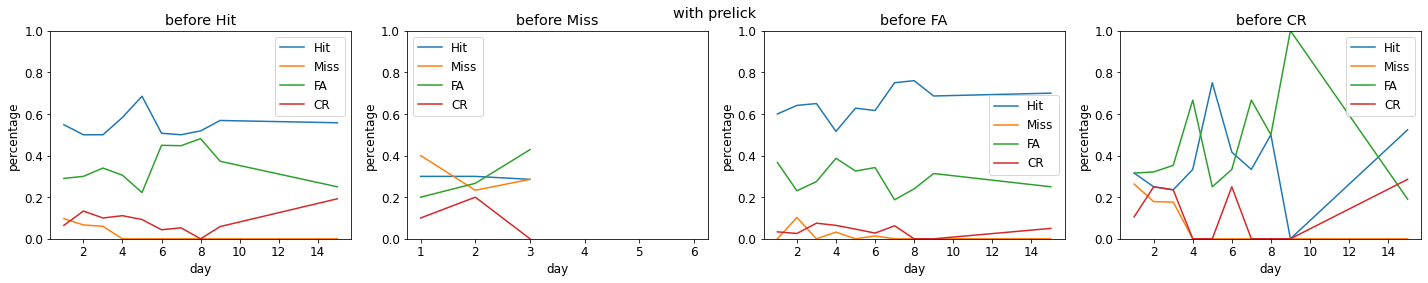

In [146]:
fig = plt.figure(figsize=(20, 4))
plt.rcParams.update({'font.size': 12})
fig.patch.set_facecolor('white')
for outcome_index in range(1,5):
    # plt.subplot(2,4,outcome_index)
    plt.subplot(1,4,outcome_index)
    plt.title('before {}'.format(outcome_list[outcome_index-1]))
    before_outcomes = nt_prelick_all[:, :, outcome_index-1] # nday, noutcome
    row_sums = before_outcomes.sum(axis=1)
    before_outcomes = before_outcomes / row_sums[:, np.newaxis]
    for i in range(4):
        plt.plot(valid_days, before_outcomes[:, i], label=outcome_list[i])
    plt.legend()
    plt.ylabel('percentage')
    plt.xlabel('day')
    plt.ylim([0,1])
plt.tight_layout()
plt.suptitle('with prelick')
plt.show()

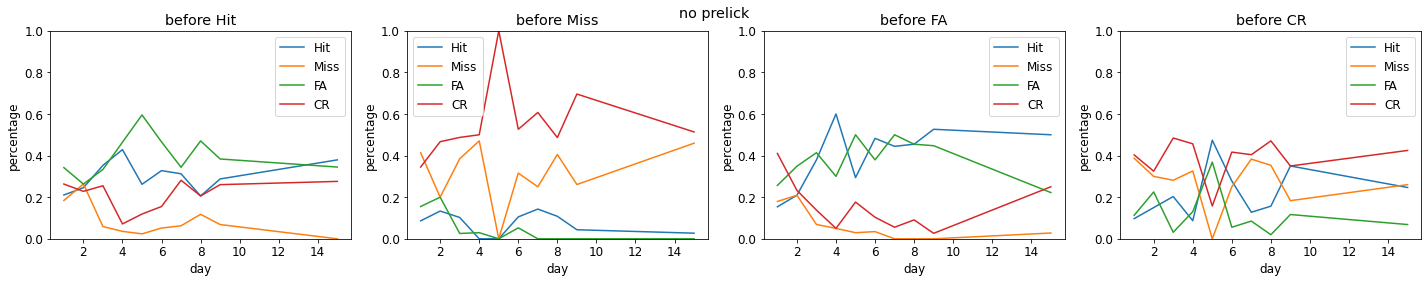

In [147]:
fig = plt.figure(figsize=(20, 4))
plt.rcParams.update({'font.size': 12})
fig.patch.set_facecolor('white')
for outcome_index in range(1,5):
    # plt.subplot(2,4,outcome_index)
    plt.subplot(1,4,outcome_index)
    plt.title('before {}'.format(outcome_list[outcome_index-1]))
    before_outcomes = nt_noprelick_all[:, :, outcome_index-1] # nday, noutcome
    row_sums = before_outcomes.sum(axis=1)
    before_outcomes = before_outcomes / row_sums[:, np.newaxis]
    for i in range(4):
        plt.plot(valid_days, before_outcomes[:, i], label=outcome_list[i])
    plt.legend()
    plt.ylabel('percentage')
    plt.xlabel('day')
    plt.ylim([0,1])
plt.tight_layout()
plt.suptitle('no prelick')
plt.show()

# pair outcome latency

In [234]:
valid_days = []
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)

prelick_latencies = []
noprelick_latencies = []
for day in valid_days:
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        lprelick = []
        lnolick = []
        for i in iblocks:
            block = data[0, i]
            behavior = block['behavdata']
            istim = np.where(behavior[0] > 0)[0] # cue onset frames
            licks = behavior[3]

            for i,k in enumerate(istim[:-1]):
                nprelicks = np.sum(licks[(istim[i+1] - 30):(istim[i+1] - 15)])
                if nprelicks > 0:
                    lprelick.append(istim[i+1] - k)
                else:
                    lnolick.append(istim[i+1] - k)
    prelick_latencies.append(np.mean(lprelick))
    noprelick_latencies.append(np.mean(lnolick))

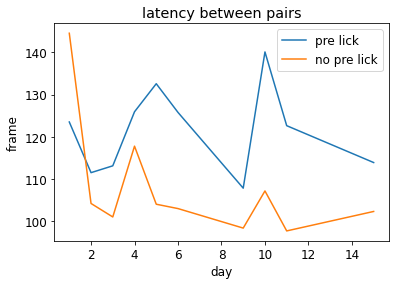

In [235]:
plt.plot(valid_days, prelick_latencies, label='pre lick')
plt.plot(valid_days, noprelick_latencies, label='no pre lick')
plt.title('latency between pairs')
plt.xlabel('day')
plt.ylabel('frame')
plt.legend()

# outcome distribution before prelick/no prelick

In [24]:
valid_days = []
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)

o_prelick = np.zeros((4, len(valid_days)))
o_nolick = np.zeros((4, len(valid_days)))

for iday, day in enumerate(valid_days):
    iblocks = daily_blocks(data, day)
    daily_cues = []
    daily_outcomes = []
    daily_responses = []
    daily_firstlicks = []
    daily_alllicks = []
    for i in iblocks:
        block = data[0, i]
        # normalize doesn't have much effect on the result, so set it to False
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=True, dff=False, remove=True)
        daily_cues.append(cues)
        daily_outcomes.append(outcomes)
        daily_responses.append(stim_resp)
        daily_firstlicks.append(firstlicks)
        daily_alllicks.append(alllicks)

    daily_cues = np.hstack(daily_cues)
    daily_outcomes = np.hstack(daily_outcomes)
    daily_responses = np.vstack(daily_responses)
    daily_firstlicks = np.hstack(daily_firstlicks)
    daily_alllicks = np.vstack(daily_alllicks)

    n_prelicks = np.sum(daily_alllicks[:, :15], axis=1)
    iprelick = np.where(n_prelicks!=0)[0]
    inolick = np.where(n_prelicks==0)[0]
    prelick_outcomes = daily_outcomes[iprelick-1] # outcomes before prelick
    nolick_outcomes = daily_outcomes[inolick - 1] # outcomes before no prelick
    ntrials = len(daily_outcomes)
    for outcome_index in range(1,5):
        o_prelick[outcome_index-1, iday] = np.sum(prelick_outcomes == outcome_index) / ntrials
        o_nolick[outcome_index-1, iday] = np.sum(nolick_outcomes == outcome_index) / ntrials

remove 0/100 trials with window size 20
remove 26/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 20/100 trials with window size 20
remove 95/100 trials with window size 20
remove 99/100 trials with window size 20
remove 56/100 trials with window size 20
remove 73/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 99/100 trials with window size 20
remove 34/100 trials with window size 20
remove 99/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 97/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 48/100 trials with window size 20
remove 0/100 trials with wind

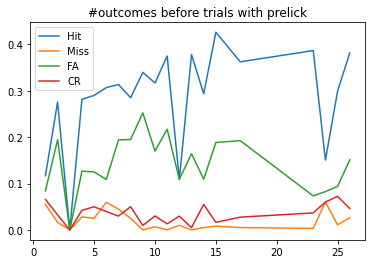

In [26]:
for i in range(4):
    plt.plot(valid_days, o_prelick[i], label=outcome_list[i])
plt.title('#outcomes before trials with prelick')
plt.legend()

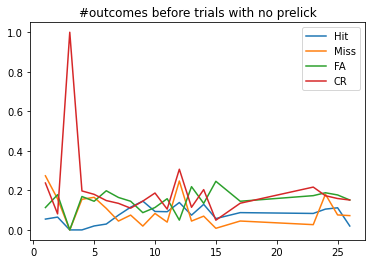

In [27]:
for i in range(4):
    plt.plot(valid_days, o_nolick[i], label=outcome_list[i])
plt.title('#outcomes before trials with no prelick')
plt.legend()

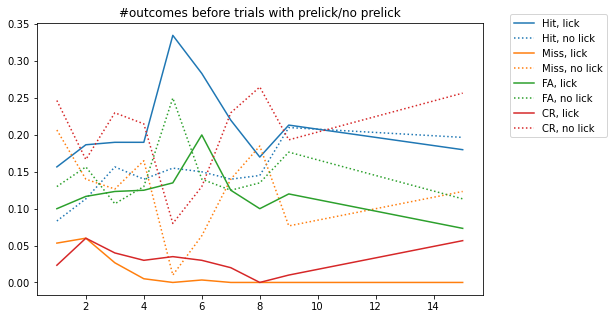

In [23]:
plt.figure(figsize=(8, 5))
cmap = plt.cm.get_cmap('tab10')
for i in range(4):
    plt.plot(valid_days, o_prelick[i], label='{}, lick'.format(outcome_list[i]), c=cmap(i))
    plt.plot(valid_days, o_nolick[i], label='{}, no lick'.format(outcome_list[i]), linestyle=':', c=cmap(i))
plt.title('#outcomes before trials with prelick/no prelick')
plt.legend(bbox_to_anchor=(1.05, 1.05))

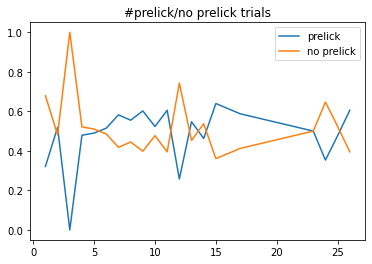

In [25]:
plt.plot(valid_days, np.sum(o_prelick, axis=0), label='prelick')
plt.plot(valid_days, np.sum(o_nolick, axis=0), label='no prelick')
plt.title('#prelick/no prelick trials')
plt.legend()

# outcome distribution after prelick/no prelick

In [34]:
valid_days = []
for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)

o_prelick = np.zeros((4, len(valid_days))) # number of outcomes in every day
o_nolick = np.zeros((4, len(valid_days)))

for iday, day in enumerate(valid_days):
    iblocks = daily_blocks(data, day)
    daily_cues = []
    daily_outcomes = []
    daily_responses = []
    daily_firstlicks = []
    daily_alllicks = []
    for i in iblocks:
        block = data[0, i]
        # normalize doesn't have much effect on the result, so set it to False
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, normalize=True, dff=False, remove=True)
        daily_cues.append(cues)
        daily_outcomes.append(outcomes)
        daily_responses.append(stim_resp)
        daily_firstlicks.append(firstlicks)
        daily_alllicks.append(alllicks)

    daily_cues = np.hstack(daily_cues)
    daily_outcomes = np.hstack(daily_outcomes)
    daily_responses = np.vstack(daily_responses)
    daily_firstlicks = np.hstack(daily_firstlicks)
    daily_alllicks = np.vstack(daily_alllicks)

    n_prelicks = np.sum(daily_alllicks[:, :15], axis=1)
    iprelick = np.where(n_prelicks!=0)[0]
    inolick = np.where(n_prelicks==0)[0]
    prelick_outcomes = daily_outcomes[iprelick] # outcomes before prelick
    nolick_outcomes = daily_outcomes[inolick] # outcomes before no prelick
    ntrials = len(daily_outcomes)
    for outcome_index in range(1,5):
        o_prelick[outcome_index-1, iday] = np.sum(prelick_outcomes == outcome_index) / ntrials
        o_nolick[outcome_index-1, iday] = np.sum(nolick_outcomes == outcome_index) / ntrials

remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 82/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 35/100 trials with window size 20
remove 0/100 trials with window size 20
remove 51/100 trials with window size 20
remove 0/100 trials with window size 20
remove 80/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 0/100 trials with window size 20
remove 71/100 trials with window size 20
remove 0/100 trials with window size 20
remove 25/100 trials with window size 20


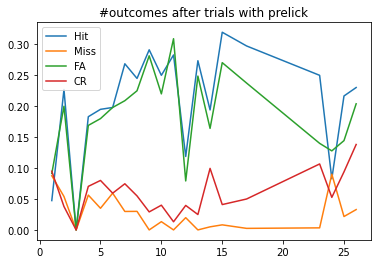

In [29]:
for i in range(4):
    plt.plot(valid_days, o_prelick[i], label=outcome_list[i])
plt.title('#outcomes after trials with prelick')
plt.legend()

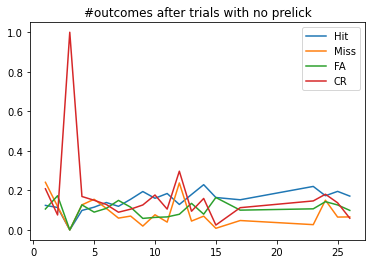

In [30]:
for i in range(4):
    plt.plot(valid_days, o_nolick[i], label=outcome_list[i])
plt.title('#outcomes after trials with no prelick')
plt.legend()

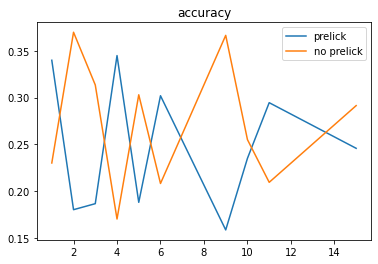

In [36]:
plt.plot(valid_days, o_prelick[0]+o_prelick[3], label='prelick')
plt.plot(valid_days, o_nolick[0]+o_nolick[3], label='no prelick')
plt.title('accuracy')
plt.legend()

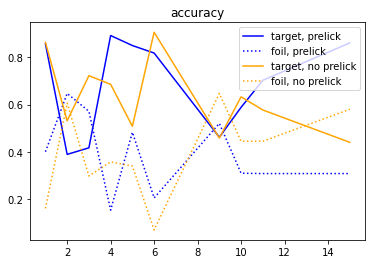

In [35]:
plt.plot(valid_days, o_prelick[0]/(o_prelick[1]+o_prelick[0]), label='target, prelick', color='blue')
plt.plot(valid_days, o_prelick[3]/(o_prelick[2]+o_prelick[3]), label='foil, prelick', color='blue', linestyle=":")
plt.plot(valid_days, o_nolick[0]/(o_nolick[1]+o_nolick[0]), label='target, no prelick', color='orange')
plt.plot(valid_days, o_nolick[3]/(o_nolick[2]+o_nolick[3]), label='foil, no prelick', color='orange', linestyle=":")
plt.title('accuracy')
plt.legend()

In [318]:
a = np.arange(10)
f = (a == 7) | (a == 3)
print(a[f])

[3 7]


In [319]:
print(f)

[False False False  True False False False  True False False]
